<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Simple-first-run" data-toc-modified-id="Simple-first-run-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simple first run</a></span></li><li><span><a href="#Use-simple-serial-algorithm" data-toc-modified-id="Use-simple-serial-algorithm-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Use simple serial algorithm</a></span></li><li><span><a href="#Use-pytorch-convolution" data-toc-modified-id="Use-pytorch-convolution-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Use pytorch convolution</a></span></li></ul></div>

In [120]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scripts import ising
from scripts import torch_ising

%load_ext autoreload
%autoreload 2

# Insight from using full energy
np.seterr(over='raise')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{'divide': 'warn', 'over': 'raise', 'under': 'ignore', 'invalid': 'warn'}

## Simple first run

1. Iniatilize NxN grid
2. Compute the initial energy $E$
3. Flip random spin and compute $\Delta E$
4. Accept or reject based on criteria
5. Continue to 3

In [52]:
#@profile
def random_ix(N, steps):
    randix = (np.random.randint(0, N, size=(steps,2)))
    return randix

In [53]:
N = 50
grid = ising.get_random_grid(N)
#plt.imshow(grid)
# Rescale to +-1

## Use simple serial algorithm

In [54]:
J = 0.5
mu = 0

temps = np.linspace(0.05, 3, 100)
eneg_tm = []
mag_tm = []
for T in temps:
    beta = 1/T
    grid = ising.get_random_grid(N)
    
    # Thermalise    
    therm_sweeps = 200
    for ix in random_ix(N, steps=N**2*therm_sweeps):
        dE = ising.metrop_step(grid, ix, J, mu, beta, N)
    
    E = [ising.ising_energy(grid, J, mu)]
    M = [np.mean(grid)]
    print('measure t=',T)
    for ix in random_ix(N, steps=N**2*100):
        raise
        dE = ising.metrop_step(grid, ix, J, mu, beta, N)
        dE = dE or 0
        E.append( E[-1] + dE )
        M.append(np.mean(grid))
        
    print('done measure')
    eneg_tm.append(E)
    mag_tm.append(M)

KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(8,6))

[ax.set_title(t) for ax, t in zip(sum(map(list, axs),[]),
                              ['Energy','Specific Heat', 'Magnetization', 'Susceptibility'])]

axs[0,0].plot(temps, list(map(np.mean, eneg_tm)))
axs[0,1].plot(temps, list(map(np.std, eneg_tm)))
axs[1,0].plot(temps, list(map(np.mean, mag_tm)))
axs[1,1].plot(temps, list(map(np.std, mag_tm)))


## Use pytorch convolution

In [190]:
J = 0.5
mu = 0

temps = np.linspace(0.05, 2, 30)
eneg_tm = []
mag_tm = []
grid = torch_ising.get_random_grid(N, device='cpu')
for T in tqdm(temps):
    beta = 1/T
    
    # Thermalise    
    therm_sweeps = 600
    conv = torch_ising.get_conv_nn(J, mu, device='cpu')
    for ix in random_ix(N, steps=9*therm_sweeps):
        grid, dE, dM = torch_ising.metrop_step(grid, conv, beta)
    
    measure_sweeps = 600
    E = [ising.ising_energy(grid[0][0], J, mu).cpu().numpy()]
    M = [grid.sum().cpu().numpy()]
    #grid = grid.cpu().numpy()[0,0]
    for ix in random_ix(N, steps=9*measure_sweeps):
        #dE = ising.metrop_step(grid, ix, J, mu, beta, N)
        grid, dE, dM = torch_ising.metrop_step(grid, conv, beta)
        dE = dE or 0
        E.append( E[-1] + dE )
        M.append( M[-1] + dM )
        
    eneg_tm.append(E)
    mag_tm.append(M)

100%|██████████| 30/30 [02:57<00:00,  5.92s/it]


In [192]:
energies = np.mean(eneg_tm, axis=1)
susc = np.std(eneg_tm, axis=1)
magnetizations = np.mean(mag_tm, axis=1)
permit = np.std(mag_tm, axis=1)


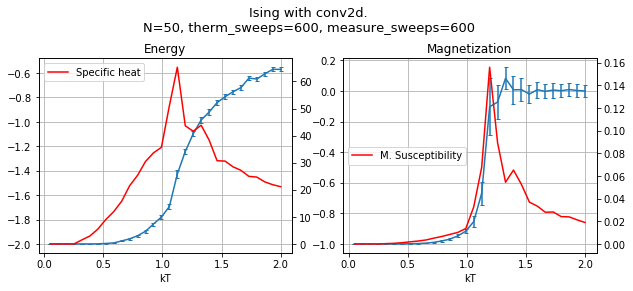

In [210]:
fig, axs = plt.subplots(1,2, figsize=(10,4))

fig.suptitle(
    ('Ising with conv2d.\n'
     f'{N=}, {therm_sweeps=}, {measure_sweeps=}\n '
    )
    #, y=1.00
    , fontsize=13
)

plt.sca(axs[0])
plt.errorbar(temps, energies/N**2
             , yerr=susc/N**2
             , capsize=2
            )
plt.gca().twinx()
plt.plot(temps, susc/temps, 'red', label='Specific heat')
plt.legend(loc='upper left')

plt.sca(axs[1])
#plt.plot(temps, magnetizations/N**2)
plt.errorbar(temps, magnetizations/N**2
             , yerr=permit/N**2
             , capsize=2
            )
plt.gca().twinx()
plt.plot(temps, permit/temps/N**2, 'red', label='M. Susceptibility')

plt.legend(loc='center left')

[ax.grid() for ax in axs]
[ax.set_title(x) for ax,x in zip(axs, ['Energy', 'Magnetization'])]
[ax.set_xlabel('kT') for ax in axs]
plt.subplots_adjust(top=0.80)


plt.savefig('../data/figures/Ising_conv2d_600sweeps.png')

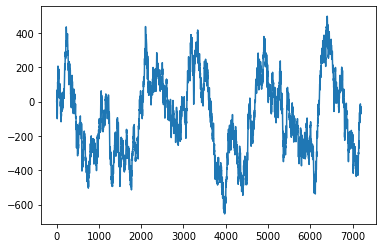

In [114]:
plt.plot(mag_tm[20])

In [ ]:
# smoothing

plt.plot(np.convolve(energies, np.ones((N**2,))/N**2, mode='valid'))


In [ ]:
fig, axs = plt.subplots(2,1, figsize=(5,5))
plt.plot(averages, label='average occupation') 
plt.legend()
plt.sca(axs[0])
plt.plot(energies, label='Energy', color='orange') 
plt.legend()

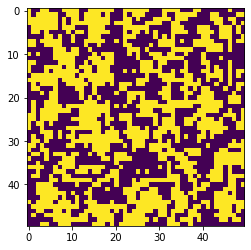

In [104]:
#grid = get_random_grid(50)
plt.imshow(grid[0,0])